# Author: Makayla McKibben
## Course: DSC550 Data Mining
## Assignment: Ex. 11.2
## Date: 11.12.2024

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from keras.datasets import mnist
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop
from sklearn.datasets import make_classification 
import torch._dynamo
from sklearn.metrics import accuracy_score
import warnings
import torchmetrics as tm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
# Suppress warnings
torch._dynamo.config.suppress_errors = True
warnings.filterwarnings('ignore')

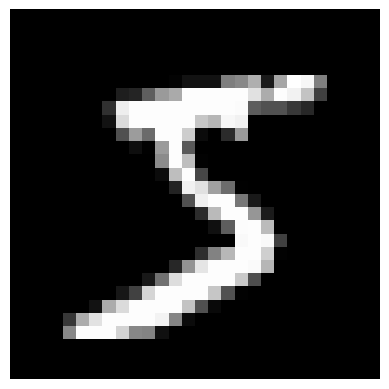

In [4]:
# Load and split the data into training and test
(X_train, Y_train) ,(X_test, Y_test) = mnist.load_data()
# Show first image in training set
plt.imshow(X_train[0], cmap="gray"), plt.axis("off")
plt.show()

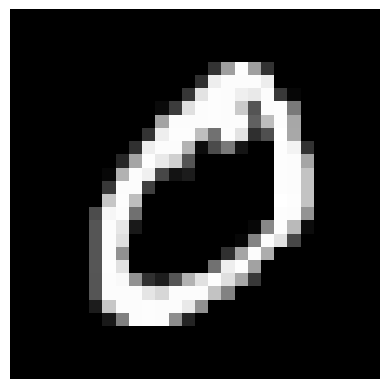

In [5]:
# Show second image in training set
plt.imshow(X_train[1],cmap="gray"), plt.axis("off")
plt.show()

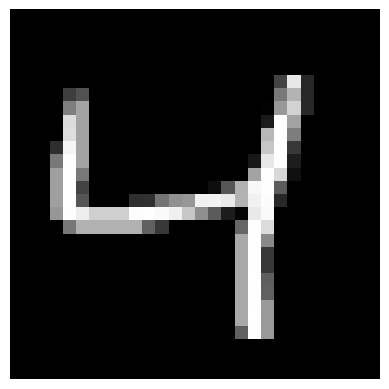

In [6]:
# Show third image in training set
plt.imshow(X_train[2],cmap="gray"), plt.axis("off")
plt.show()

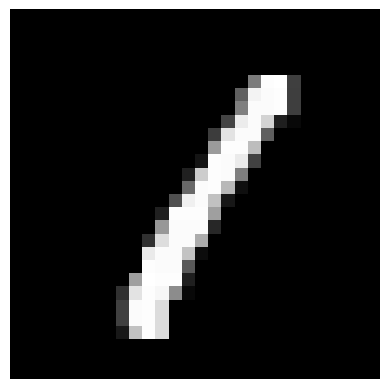

In [7]:
# Show fourth image in training set
plt.imshow(X_train[3],cmap="gray"), plt.axis("off")
plt.show()

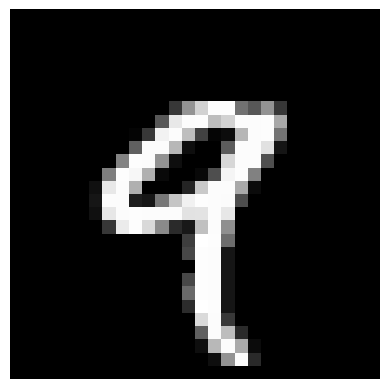

In [8]:
# Show fifth image in training set
plt.imshow(X_train[4],cmap="gray"), plt.axis("off")
plt.show()

In [9]:
# Set number of classes to 10 for each digit
n_classes = 10
# Set 8 epochs for 8 passes through the data forward and backward
epochs = 8

In [10]:
# Convert to tensor floats
x_train = torch.from_numpy(X_train).float()
# One hot encode and convert to tensor
y_train = torch.nn.functional.one_hot(torch.from_numpy(Y_train).long(), num_classes = n_classes).long()

In [11]:
# Convert to tensor floats
x_test = torch.from_numpy(X_test).float()
# One hot encode and convert to tensor
y_test = torch.nn.functional.one_hot(torch.from_numpy(Y_test).long(), num_classes = n_classes).float()

In [12]:
# Define neuralnet class/neural network
class neuralnet(nn.Module):
    def __init__(self):
        super(neuralnet, self).__init__()
        self.sequential = torch.nn.Sequential(torch.nn.Linear(28, 56), torch.nn.Softmax(), torch.nn.Linear(56, 56), torch.nn.Softmax(), torch.nn.Linear(56, 10), torch.nn.Softmax())
    # Define the forward function of the neural network using sequential
    def forward(self, x):
        x = self.sequential(x)
        return x

In [13]:
# Create/initialize a neural network
network = neuralnet()

In [14]:
# Define loss funtion
criterion = nn.CrossEntropyLoss()
# Define optimizer
optimizer = RMSprop(network.parameters())

In [15]:
# Define data loader
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size = 80, shuffle = True)

In [16]:
# Complie the model
network = torch.compile(network)

In [17]:
# Train the neural network
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125] WON'T CONVERT forward C:\Users\makay\AppData\Local\Temp\ipykernel_10344\173560878.py line 7 
W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125] due to: 
W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125] Traceback (most recent call last):
W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125]   File "C:\Users\makay\anaconda3\Lib\site-packages\torch\_inductor\cpp_builder.py", line 130, in check_compiler_exist_windows
W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125]     subprocess.check_output([compiler, "/help"], stderr=subprocess.STDOUT)
W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125]   File "C:\Users\makay\anaconda3\Lib\subprocess.py", line 466, in check_output
W1113 21:24:46.068000 10344 site-packages\torch\_dynamo\convert_frame.py:1125]     return run(*popenargs, std

In [18]:
# Make predictions on our test set using the neural network we've made
with torch.no_grad():
    preds = network.forward(x_test).round()

In [19]:
# Check shapes
preds.shape, y_test.shape

(torch.Size([10000, 28, 10]), torch.Size([10000, 10]))

In [20]:
# Drop dimension
preds = preds[:, 0, :]

In [21]:
# Use argmax to undo the one_hot encoding
preds = torch.argmax(preds, dim = 1)
y_test = torch.argmax(y_test, dim = 1)

In [22]:
# Calculate and print the accuracy
print('Accuracy is: ', accuracy_score(preds, y_test) * 100, '%')

Accuracy is:  9.8 %


In [23]:
# Create confusion matrix
cm = confusion_matrix(y_test, preds)

In [24]:
# Make labels
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
# Set up confusion matrix for display
disp = ConfusionMatrixDisplay(cm, display_labels = labels)

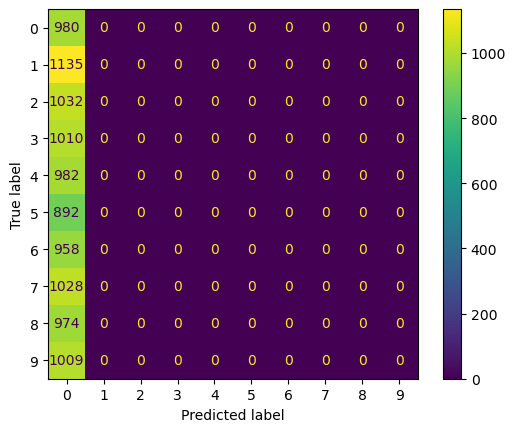

In [26]:
# Show the confusion matrix
disp.plot()
plt.show()

I realize only now that I skimmed the instructions and used Pytorch to create my model instead of Keras, sorry about that that's on me. To summarize my results, my confusion matrix I think is a bit misleading. It's showing the predicted accuracy at ~10% because it is saying all the predictions were zero. I think it's not actually predicting only zero but because of the argmax function it's pulling the indices which are zero. I'm hoping to go over this with you to try and get a better grasp on how I could actually calculate accuracy correctly and not skew my confusion matrix.